# Multimodal FinRobot with MplFinance plotting

In this demo, we set up an multimodal agent with GPT-4V using the **MultimodalConversableAgent** provided in AutoGen.

With the vision capability introduced by multimodal agents, we can analyse stock's performance through With the visual capabilities provided by the multimodal agent, we can, like regular investors, display the stock price fluctuations and trading volume of a stock over a certain period using the plotting capabilities provided by mplfinance, all on one image. Then we analyze its subsequent trend.

In [11]:
import os
import autogen
from autogen import AssistantAgent, UserProxyAgent
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.cache import Cache

from finrobot.utils import get_current_date, register_keys_from_json
from finrobot.data_source.finnhub_utils import FinnHubUtils
from finrobot.functional.charting import MplFinanceUtils

from textwrap import dedent
from matplotlib import pyplot as plt
from PIL import Image

In [12]:
config_list_4v = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST",
    filter_dict={
        "model": ["azure-gpt"],
    },
)
config_list_gpt4 = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST",
    filter_dict={
        "model": ["azure-gpt"],
    },
)

# Register FINNHUB API keys for later use
register_keys_from_json("../config_api_keys")

# Intermediate results/charts will be saved in this directory
working_dir = "./coding"
os.makedirs(working_dir, exist_ok=True)

For this task, we need:
- A normal llm agent as data provider: Call charting functions and provide instructions for multimodal agent
- A multimodal agent as market analyst: Extract the necessary information from the chart and analyze the future trend of this stock.
- A user proxy to execute python functions and control the conversations.

In [13]:
market_analyst = MultimodalConversableAgent(
    name="Market_Analyst",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0},
    system_message=dedent("""
        Your are a Market Analyst. Your task is to analyze the financial data and market news.
        Reply "TERMINATE" in the end when everything is done.
        """)
)
data_provider = AssistantAgent(
    name="Data_Provider",
    llm_config={"config_list": config_list_gpt4, "temperature": 0},
    system_message=dedent("""
        You are a Data Provider. Your task is to provide charts and necessary market information.
        Use the functions you have been provided with.
        Reply "TERMINATE" in the end when everything is done.
        """)
)
user_proxy = UserProxyAgent(
    name="User_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "") and x.get(
        "content", "").endswith("TERMINATE"),
    code_execution_config={
        "work_dir": working_dir,
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

To improve operational efficiency, we equip the data provider with our predefined tools for plotting using the `mplfinance` library and for retrieving recent market news using `Finnhub`. This approach prevents the agent from consuming extra tokens to write the functions they need.

In [14]:
from finrobot.toolkits import register_toolkits

tools = [
    {
        "function": FinnHubUtils.get_company_news,
        "name": "get_company_news",
        "description": "retrieve market news related to designated company"
    },
    {
        "function": MplFinanceUtils.plot_stock_price_chart,
        "name": "plot_stock_price_chart",
        "description": "plot stock price chart of designated company"
    }
]
register_toolkits(tools, data_provider, user_proxy)

To prevent unexpected chat sequence arrangements in group chats, we opt for manual orchestration for this task. After the data provider supplies the data, the user proxy summarizes it and then presents it to the Multimodal market analyst for analysis.


********************************************************************************
Starting a new chat....

********************************************************************************
User_proxy (to Data_Provider):


Gather information available upon 2025-01-02 for Tesla, 
including its recent market news and a candlestick chart of the stock 
price trend. Save the chart in `./coding/result.jpg`


--------------------------------------------------------------------------------
Data_Provider (to User_proxy):

***** Suggested tool call (call_rfXqZBLee3cLQuu9qOCF0EYX): get_company_news *****
Arguments: 
{"symbol": "TSLA", "start_date": "2025-01-01", "end_date": "2025-01-02", "max_news_num": 10}
*********************************************************************************
***** Suggested tool call (call_VHKizoiVopYqPBzrQWPFVwJi): plot_stock_price_chart *****
Arguments: 
{"ticker_symbol": "TSLA", "start_date": "2025-01-01", "end_date": "2025-01-02", "save_path": "./coding/result.jpg"

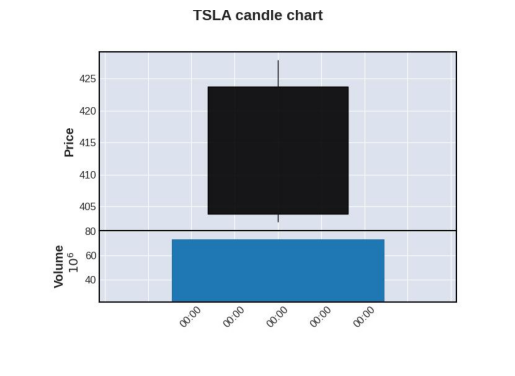

In [15]:
company = "Tesla"
# company = "APPLE"

with Cache.disk() as cache:  # image cannot be cached
    autogen.initiate_chats(
        [
            {
                "sender": user_proxy,
                "recipient": data_provider,
                "message": dedent(f"""
                Gather information available upon {get_current_date()} for {company}, 
                including its recent market news and a candlestick chart of the stock 
                price trend. Save the chart in `{working_dir}/result.jpg`
                """),           # As currently AutoGen has the bug of not respecting `work_dir` when using function call, we have to specify the directory
                "clear_history": True,
                "silent": False,
                "summary_method": "last_msg",
            },
            {
                "sender": user_proxy,
                "recipient": market_analyst,
                "message": dedent(f"""
                With the stock price chart provided, along with recent market news of {company}, 
                analyze the recent fluctuations of the stock and the potential relationship with 
                market news. Provide your predictive analysis for the stock's trend in the coming 
                week. Reply TERMINATE when the task is done.
                """),
                "max_turns": 1,  # max number of turns for the conversation
                "summary_method": "last_msg",
                # cheated here for stability
                "carryover": f"<img {working_dir}/result.jpg>"
            }
        ]
    )

img = Image.open(f"{working_dir}/result.jpg")
plt.imshow(img)
plt.axis("off")  # Hide the axes
plt.show()